# Multiple States

## Review

We just covered state schema as well as reducers.

Typically, all graph nodes communicate with a single schema that we define.

This single schema is the overall graph input / output.


## Goals

But, there are cases where we may want a bit more control over this:

* Internal nodes may pass information that is not required in the overall graph input / output.

* We may also want to use different overall input / output schemas.

Here's we'll discuss a few ways to tackle these.

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph

## Private State

First, let's cover the case of passing [private state](https://langchain-ai.github.io/langgraph/how-tos/pass_private_state/) between nodes.

This is useful for anything needed as part of the intermediate working logic of the graph, but not relevant in the overall state.

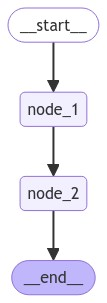

In [4]:
from typing import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class OverallState(TypedDict):
    foo: int

class PrivateState(TypedDict):
    baz: int

def node_1(state: OverallState) -> PrivateState:
    print("---Node 1---")
    return {"baz": state['foo'] + 1}

def node_2(state: PrivateState) -> OverallState:
    print("---Node 2---")
    return {"foo": state['baz'] + 1}

# Build graph
builder = StateGraph(OverallState)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"foo" : 1})

---Node 1---
---Node 2---


{'foo': 3}

You can see that `baz` is excluded from the graph output because it is not in `OverallState`.

## Input / Output Schema

By default, `StateGraph` takes in a single schema and all nodes are expected to communicate with that schema. 

However, it is also possible to [define explicit input and output schemas for a graph](https://langchain-ai.github.io/langgraph/how-tos/input_output_schema/?h=input+outp).

In [6]:
class InputState(TypedDict):
    question: str

class OutputState(TypedDict):
    answer: str

def answer_node(state: InputState):
    return {"answer": "bye"}

graph = StateGraph(input=InputState, output=OutputState)
graph.add_node(answer_node)
graph.add_edge(START, "answer_node")
graph.add_edge("answer_node", END)
graph = graph.compile()

graph.invoke({"question": "hi"})

{'answer': 'bye'}

Notice that the output of invoke only includes the output schema.